### Check if we can grab a large enough dataset from the census

In [14]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import cellxgene_census
from sklearn.model_selection import train_test_split
from cellxgene_census.experimental import get_embedding, get_embedding_metadata, get_all_available_embeddings

# 1. Choose a Census version and organism
ORGANISM = "homo_sapiens"
MEASUREMENT = "RNA"
CENSUS_VERSION = "2025-01-30"

SEED = 42

METADATA_FIELDS = [
    "assay",
    "dataset_id",
    "cell_type",
    "development_stage",
    "disease",
    "self_reported_ethnicity",
    "sex",
    "tissue_general",
    
]

SAMPLE_SIZE = 200000

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

In [2]:
# get metadata
with cellxgene_census.open_soma(census_version=CENSUS_VERSION) as census:
    cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
        value_filter = "is_primary_data == True",
    )

    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

In [4]:
cell_metadata

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,5716,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,17691.0,1199,14.754796,624.620960,19149
1,5717,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13612.0,841,16.185493,1394.944123,19149
2,5718,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,126774.0,1683,75.326203,42215.146798,19149
3,5719,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,14370.0,371,38.733154,4639.990763,19149
4,5720,a5d95a42-0137-496f-8a60-101e17f263c8,Smart-seq2,EFO:0008931,naive B cell,CL:0000788,26-year-old stage,HsapDv:0000120,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,13738.0,507,27.096647,3874.079574,19149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62634121,106118162,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,10x 3' v3,EFO:0009922,pvalb GABAergic cortical interneuron,CL:4023018,88-year-old stage,HsapDv:0000214,dementia,MONDO:0001627,...,dorsolateral prefrontal cortex,UBERON:0009834,tissue,brain,UBERON:0000955,8943.0,3764,2.375930,68.925607,36412
62634122,106118163,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,10x 3' v3,EFO:0009922,VIP GABAergic cortical interneuron,CL:4023016,81-year-old stage,HsapDv:0000207,dementia,MONDO:0001627,...,dorsolateral prefrontal cortex,UBERON:0009834,tissue,brain,UBERON:0000955,25608.0,6572,3.896531,111.678229,36412
62634123,106118164,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,10x 3' v3,EFO:0009922,L2/3-6 intratelencephalic projecting glutamate...,CL:4023040,78-year-old stage,HsapDv:0000172,normal,PATO:0000461,...,dorsolateral prefrontal cortex,UBERON:0009834,tissue,brain,UBERON:0000955,49828.0,8392,5.937560,414.247561,36412
62634124,106118165,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,10x 3' v3,EFO:0009922,astrocyte of the cerebral cortex,CL:0002605,75-year-old stage,HsapDv:0000169,normal,PATO:0000461,...,dorsolateral prefrontal cortex,UBERON:0009834,tissue,brain,UBERON:0000955,5770.0,2918,1.977382,44.125645,36412


In [8]:
obs = cell_metadata[METADATA_FIELDS].copy()
obs

,assay,dataset_id,cell_type,development_stage,disease,self_reported_ethnicity,sex,tissue_general
0,Smart-seq2,a5d95a42-0137-496f-8a60-101e17f263c8,naive B cell,26-year-old stage,normal,unknown,male,blood
1,Smart-seq2,a5d95a42-0137-496f-8a60-101e17f263c8,naive B cell,26-year-old stage,normal,unknown,male,blood
2,Smart-seq2,a5d95a42-0137-496f-8a60-101e17f263c8,naive B cell,26-year-old stage,normal,unknown,male,blood
3,Smart-seq2,a5d95a42-0137-496f-8a60-101e17f263c8,naive B cell,26-year-old stage,normal,unknown,male,blood
4,Smart-seq2,a5d95a42-0137-496f-8a60-101e17f263c8,naive B cell,26-year-old stage,normal,unknown,male,blood
...,...,...,...,...,...,...,...,...
62634121,10x 3' v3,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,pvalb GABAergic cortical interneuron,88-year-old stage,dementia,European,female,brain
62634122,10x 3' v3,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,VIP GABAergic cortical interneuron,81-year-old stage,dementia,"Native American,Hispanic or Latin American",female,brain
62634123,10x 3' v3,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,L2/3-6 intratelencephalic projecting glutamate...,78-year-old stage,normal,Asian,male,brain
62634124,10x 3' v3,6f7fd0f1-a2ed-4ff1-80d3-33dde731cbc3,astrocyte of the cerebral cortex,75-year-old stage,normal,European,male,brain


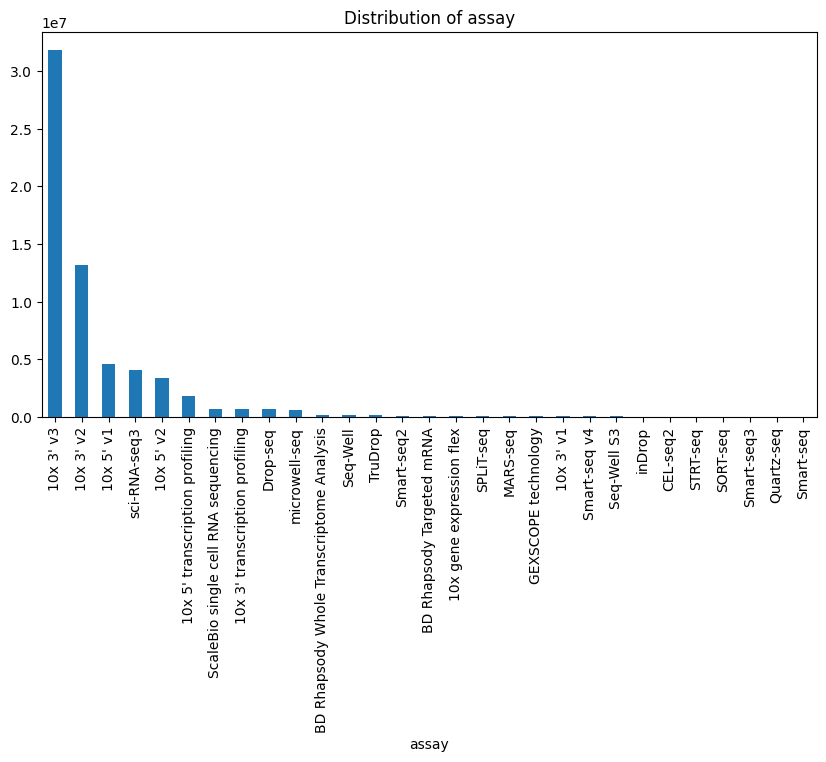

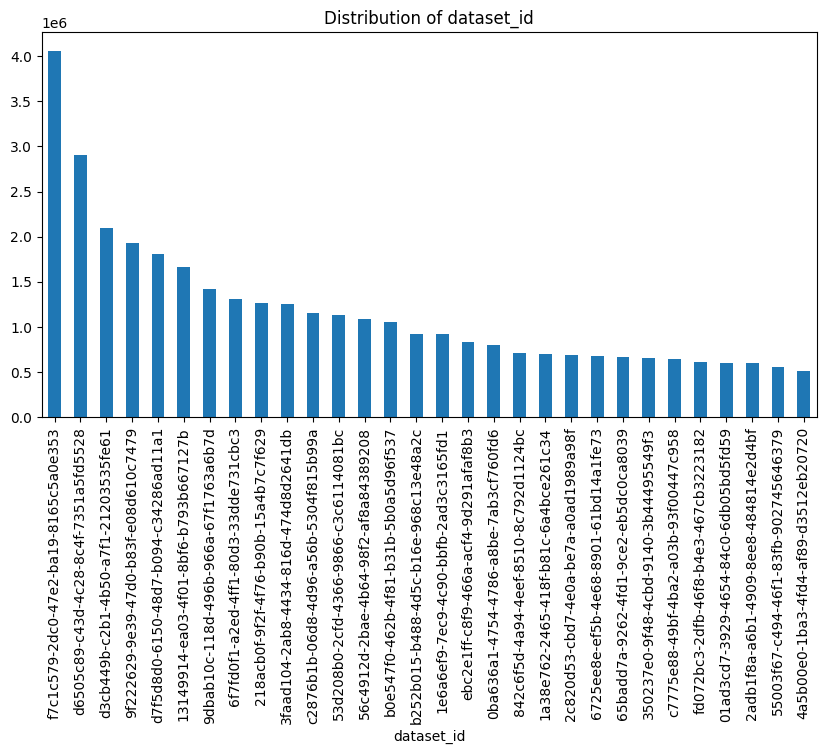

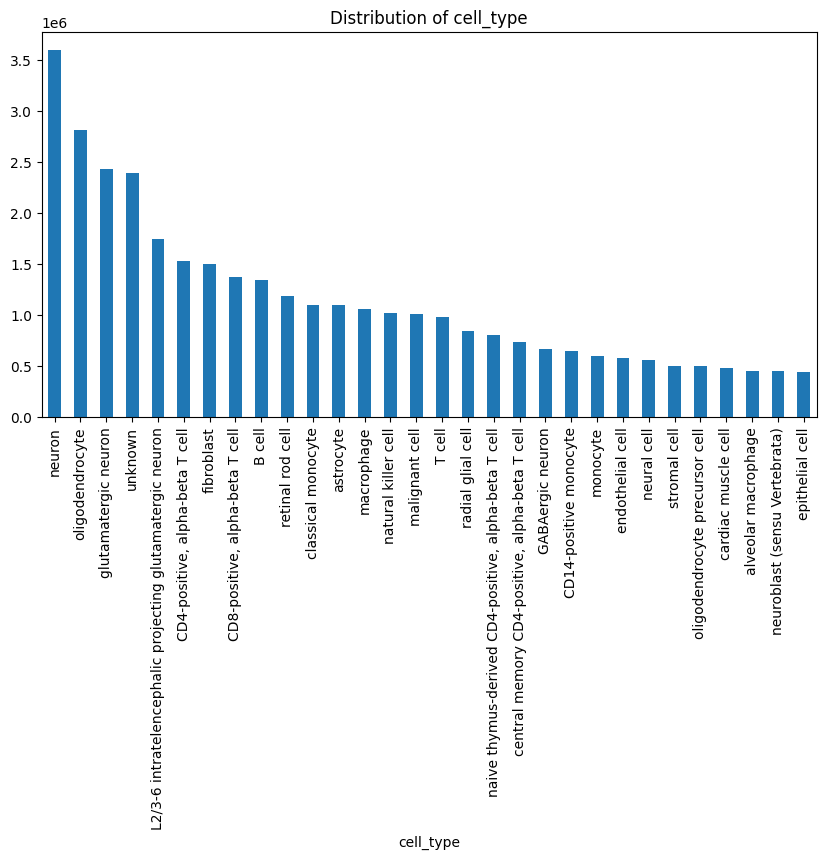

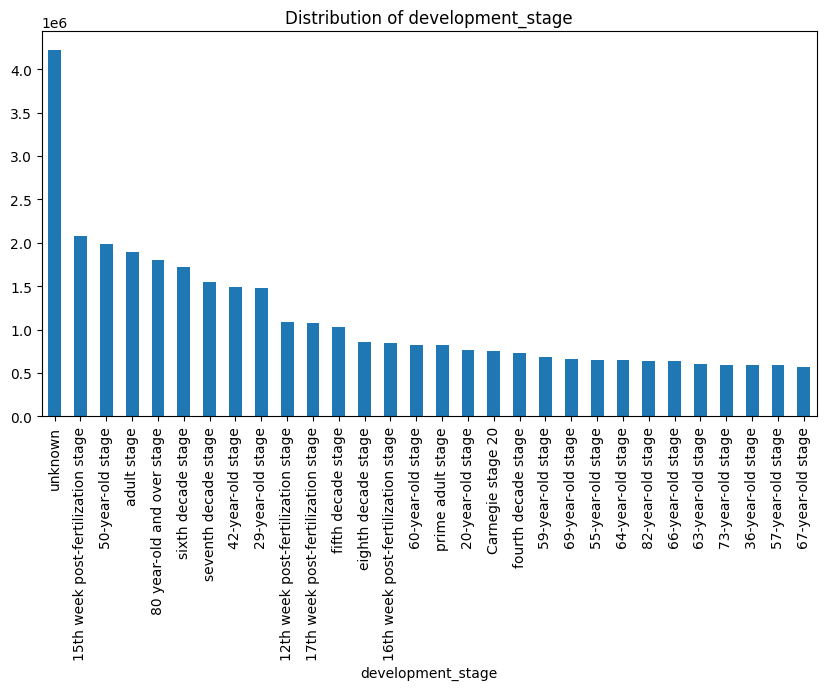

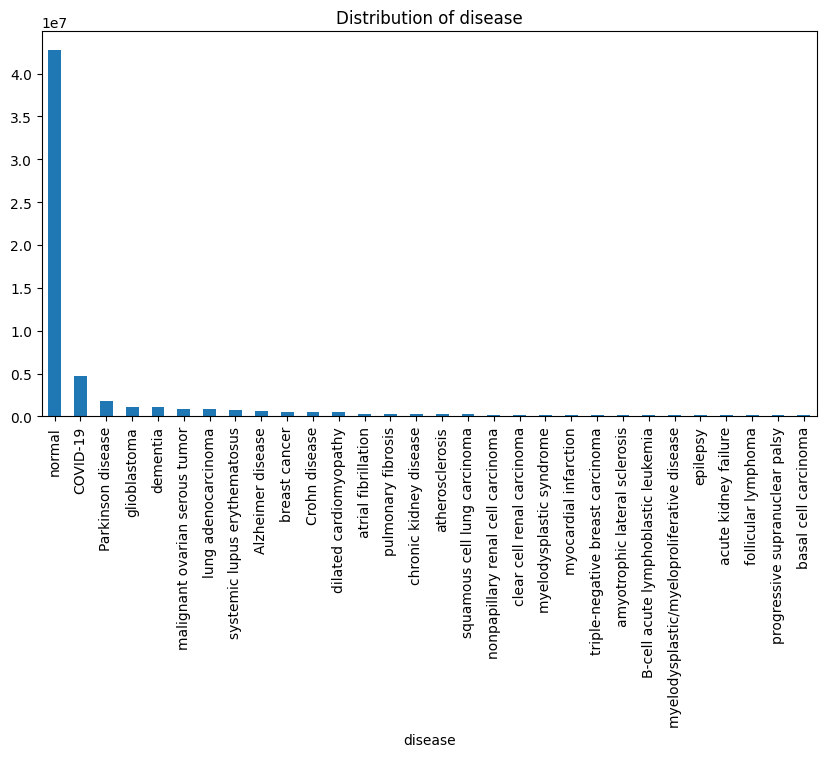

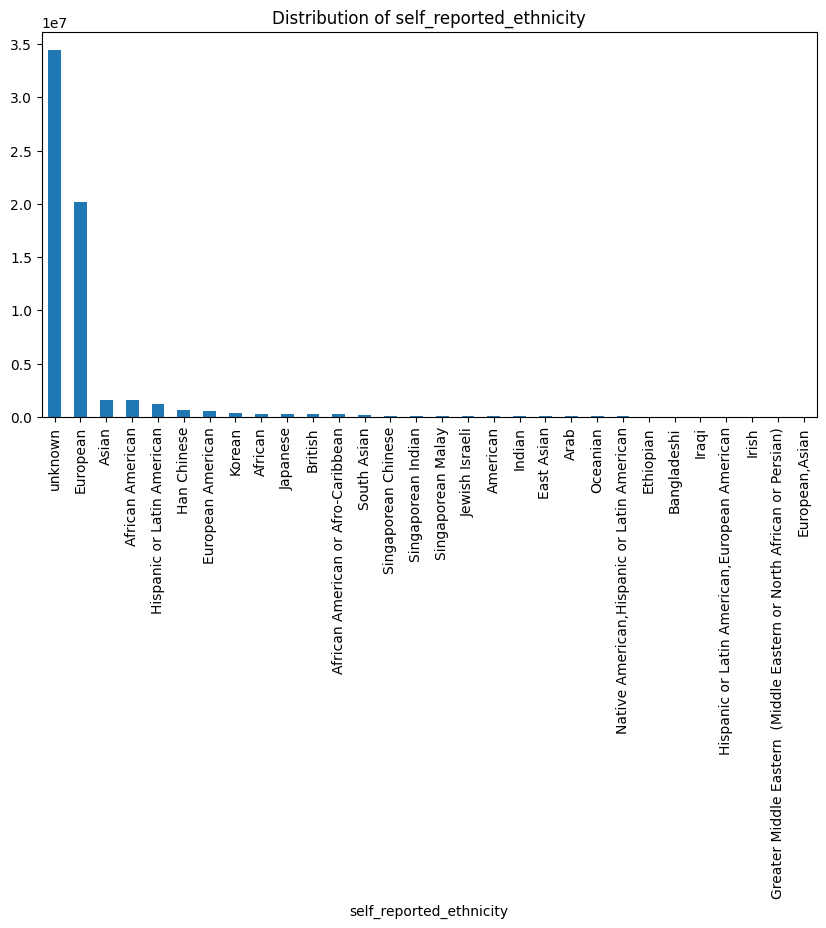

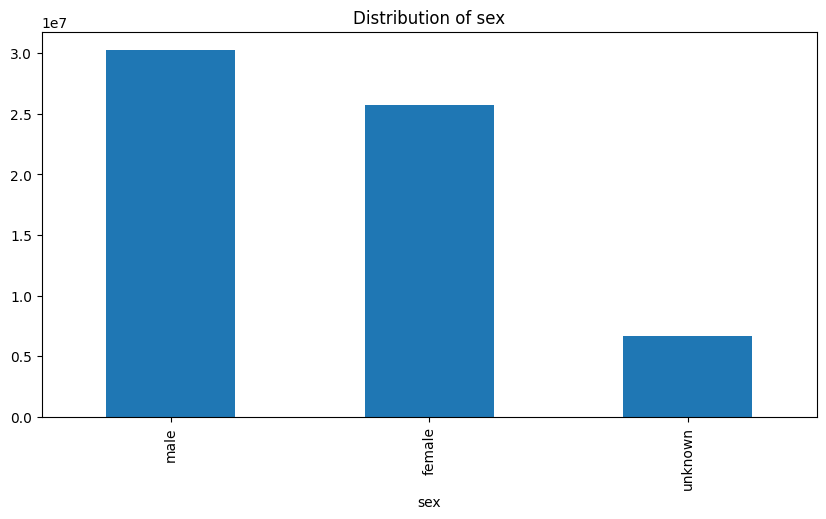

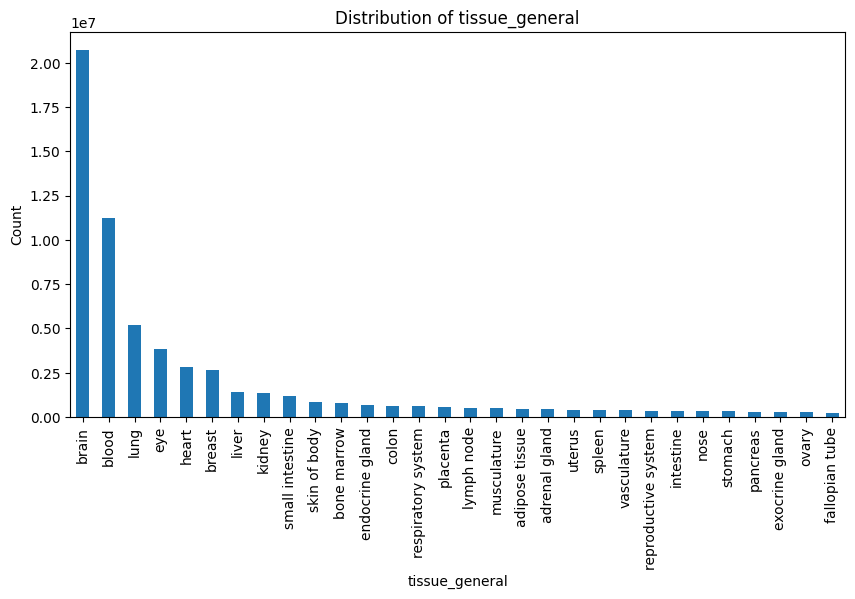

In [24]:
# quick plots:
def plot_metadata_distribution(obs, metadata_fields):
    for field in metadata_fields:
        plt.figure(figsize=(10, 5))
        obs[field].value_counts().head(30).plot(kind='bar')
        plt.title(f"Distribution of {field}")
        plt.xlabel(field)
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    plt.show()

plot_metadata_distribution(obs, METADATA_FIELDS)

In [18]:
# subsample randomly to a million cells
sampled_obs = obs.sample(n=1_000_000, random_state=SEED)

In [22]:
sampled_obs['stratify_group'] = sampled_obs[["tissue_general", "cell_type", "disease"]].astype(str).agg("_".join, axis=1)
group_sizes = sampled_obs['stratify_group'].value_counts()
sampled_obs['sample_weight'] = 1 / group_sizes[sampled_obs['stratify_group']].values

# Sample cells proportional to weights
sampled_obs = sampled_obs.sample(n=min(SAMPLE_SIZE, len(sampled_obs)), weights='sample_weight', random_state=SEED)

In [23]:
sampled_obs

,assay,dataset_id,cell_type,development_stage,disease,self_reported_ethnicity,sex,tissue_general,stratify_group,sample_weight
36799218,10x 5' v1,fd072bc3-2dfb-46f8-b4e3-467cb3223182,endothelial cell,15th week post-fertilization stage,normal,unknown,female,spleen,spleen_endothelial cell_normal,0.004926
14720701,10x 3' v2,4ed927e9-c099-49af-b8ce-a2652d069333,glandular epithelial cell,fourth decade stage,normal,unknown,female,mucosa,mucosa_glandular epithelial cell_normal,0.125000
47738220,10x 3' v2,d7f5d8d0-6150-48d7-b094-c34286ad11a1,interneuron,63-year-old stage,normal,unknown,male,brain,brain_interneuron_normal,0.001972
3293022,10x 3' v3,595c9010-99ec-462d-b6a1-2b2fe5407871,choroid plexus epithelial cell,66-year-old stage,influenza,European,male,brain,brain_choroid plexus epithelial cell_influenza,0.027027
666092,10x 3' v2,36c867a7-be10-4e69-9b39-5de12b0af6da,enterocyte of epithelium proper of ileum,prime adult stage,Crohn ileitis,unknown,unknown,small intestine,small intestine_enterocyte of epithelium prope...,0.125000
...,...,...,...,...,...,...,...,...,...,...
3273737,10x 3' v3,595c9010-99ec-462d-b6a1-2b2fe5407871,choroid plexus epithelial cell,85-year-old stage,aspiration pneumonia,European,male,brain,brain_choroid plexus epithelial cell_aspiratio...,0.007042
57195550,10x 3' v3,d6505c89-c43d-4c28-8c4f-7351a5fd5528,diffuse bipolar 4 cell,80 year-old and over stage,normal,Hispanic or Latin American,male,eye,eye_diffuse bipolar 4 cell_normal,0.001399
33480842,10x 3' v3,65badd7a-9262-4fd1-9ce2-eb5dc0ca8039,endothelial cell,sixth decade stage,dilated cardiomyopathy,European,male,heart,heart_endothelial cell_dilated cardiomyopathy,0.000757
34809066,10x 3' v3,b252b015-b488-4d5c-b16e-968c13e48a2c,fibroblast,55-year-old stage,malignant ovarian serous tumor,Asian,female,omentum,omentum_fibroblast_malignant ovarian serous tumor,0.001534


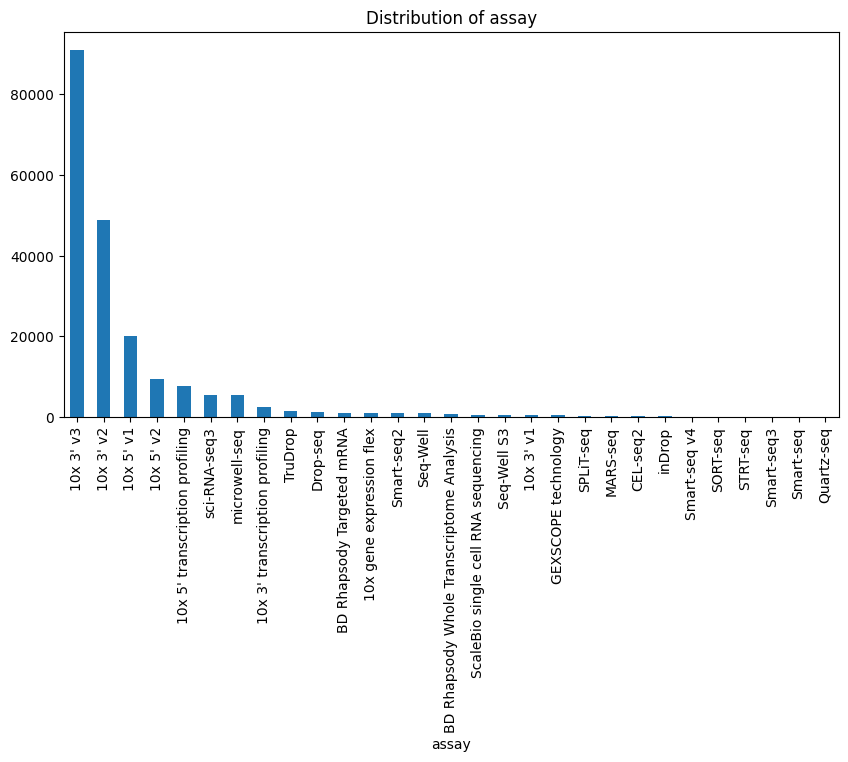

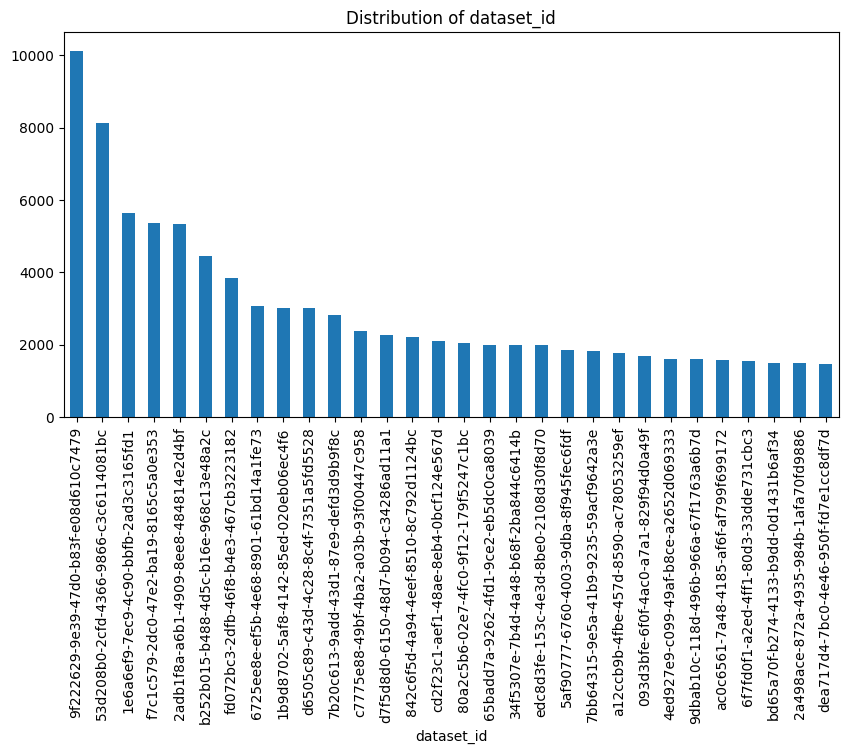

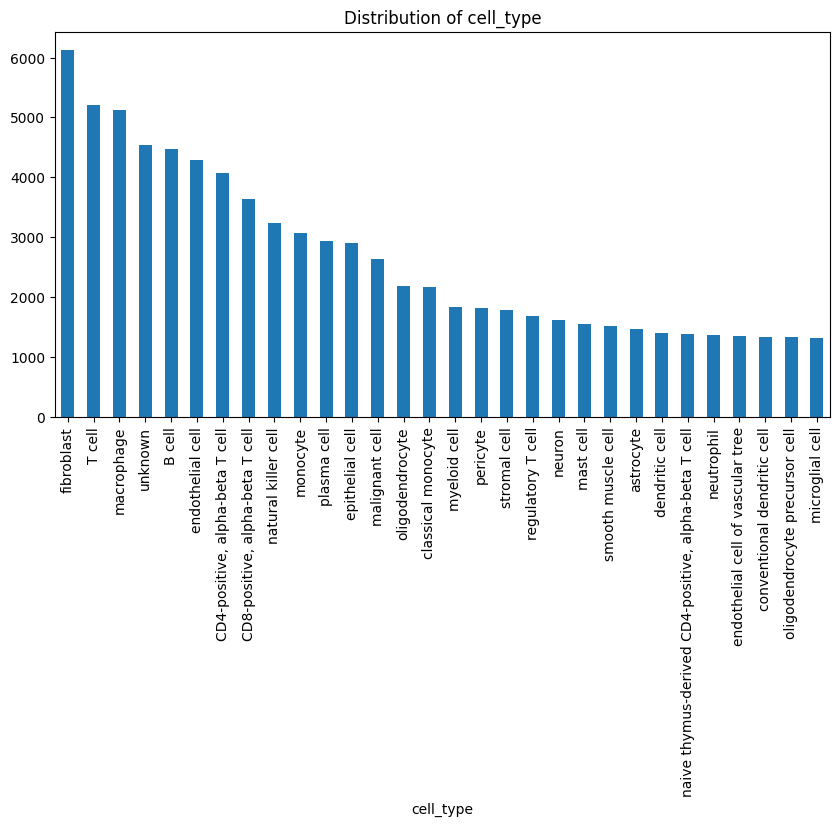

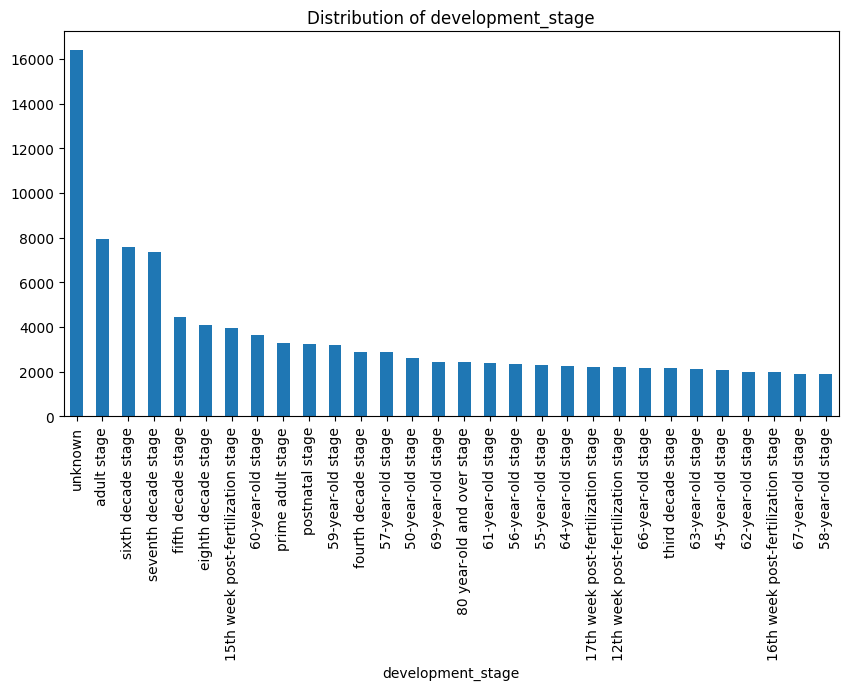

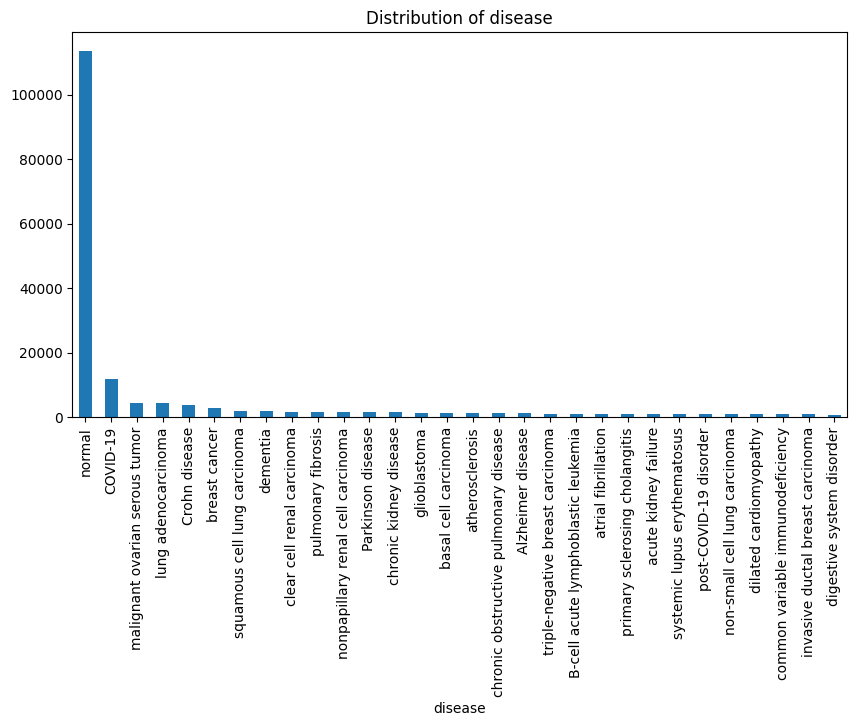

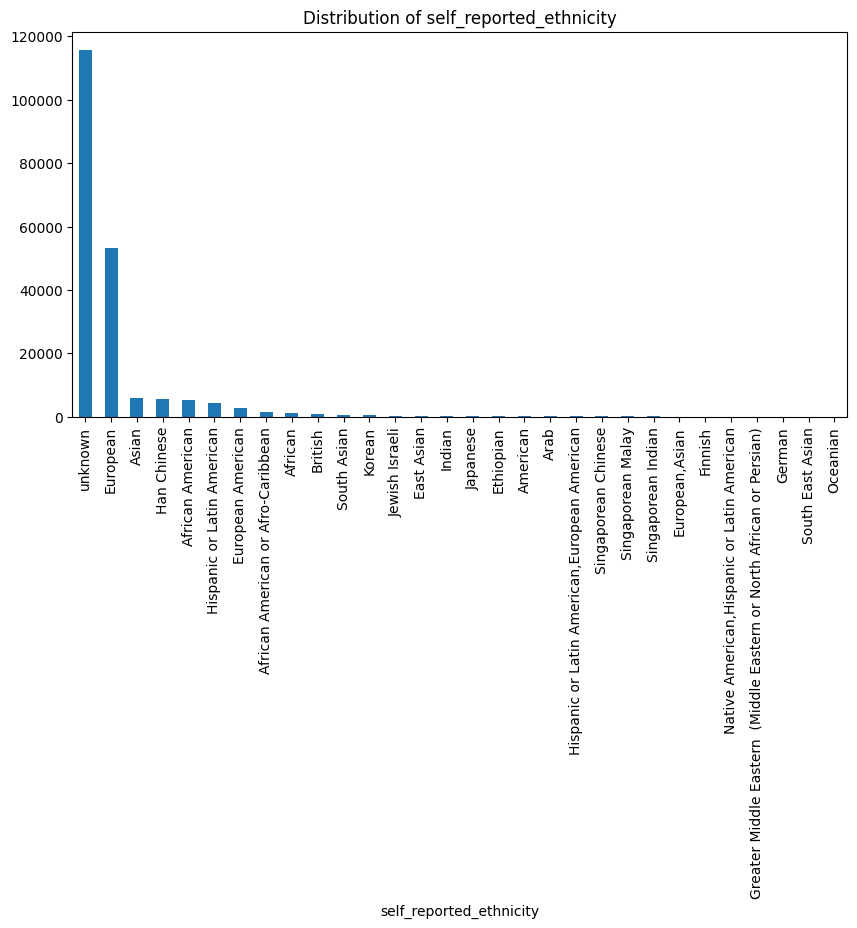

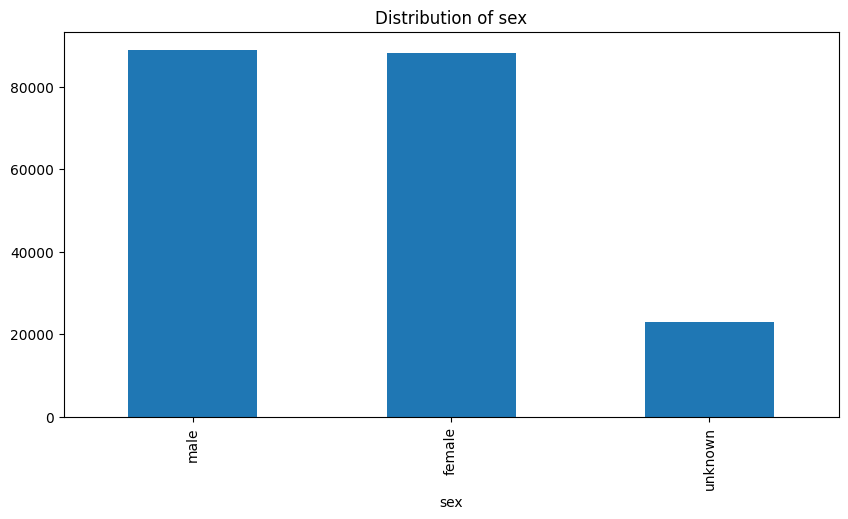

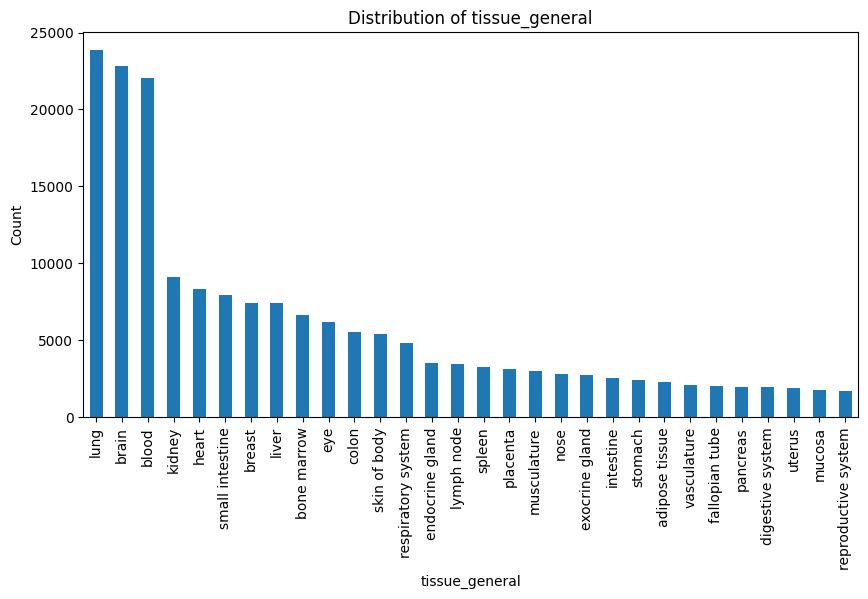

In [25]:
plot_metadata_distribution(sampled_obs, METADATA_FIELDS)

In [26]:
# check value counts of cell_type
sampled_obs['cell_type'].value_counts()

cell_type
fibroblast                               6123
T cell                                   5200
macrophage                               5123
unknown                                  4532
B cell                                   4476
                                         ... 
adult skeletal muscle myoblast              0
serous cell of epithelium of bronchus       0
enterochromaffin-like cell                  0
leptomeningeal cell                         0
brush cell of trachea                       0
Name: count, Length: 819, dtype: int64